In [136]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import itertools
import warnings

In [137]:
class ComputationalGraph():
    """Represents a computational graph."""

    def __init__(self):
        # The graph in the form of an adjacency list. 
        # Each key in the dictionary is a Node ID and the corresponding value 
        # is the list of ID's of edges that originate from that Node.
        self.forwardAdj = {}

        # Dictionary of backward edge connections.
        self.backwardAdj = {}
        
        # The set of ID's of edges that belong to the computational graph.
        self.edges = set()
    
    
    def add_node(self, nodeId):
        """Add a node to the graph."""
        try:
            _ = Node.get(nodeId)
        except KeyError:
            raise
       
        if nodeId in self.forwardAdj:
            warnings.warn("Warning..... Atempting to add node that already exists in Computational Graph. Ignored.")
            return
        
        self.forwardAdj[nodeId] = []
        self.backwardAdj[nodeId] = []

    
    def add_edge(self, edgeId):
        """Add an edge to the graph."""
        try:
            edge = Edge.get(edgeId)
        except KeyError:
            raise

        if edgeId in self.edges:
            warnings.warn("Warning..... Atempting to add edge that already exists in Computational Graph. Ignored.")
            return
        
        if edge.nodeFromId not in self.forwardAdj or edge.nodeToId not in self.forwardAdj:
            raise ValueError('Both nodes of the edge must belong to the Computational Graph')

        self.edges.add(edgeId)
        self.forwardAdj[edge.nodeFromId].append(edgeId)
        self.backwardAdj[edge.nodeToId].append(edgeId)

    def getConnectedComponent(self, nodeId):
        """Return a connected component containing node with given Id.
        Assumes undirected graph.
        """
        visited = {}
        connectedComponent = []
        
        def dfs(nodeId, graph):
            """Perform a depth-first-traversal from the given node, 
            adding each node id on the path to the connectedCOmponent list.
            """
            visited[nodeId] = True
            connectedComponent.append(nodeId)
            for edgeId in graph.forwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                neighbourId = edge.nodeToId
                if neighbourId not in visited:
                    dfs(neighbourId, graph)
            for edgeId in graph.backwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                neighbourId = edge.nodeFromId
                if neighbourId not in visited:
                    dfs(neighbourId, graph)
            
        dfs(nodeId, self)
        return connectedComponent

    
    def getTopSort(self, containedNodeId=None):
        """Return the list of ID's of Nodes in the graph sorted in Topological order.
        This is useful for backward propagation of gradients as the order in which 
        nodes need to be visited while passing gradients backwards is the reverse
        topological ordering.

        Args:
            containedNodeId: Topological sort of the connected component to which
                              the node with containedNodeId belongs is returned. 
                              Entire topological sort is returned if containedNodeId
                              is None.
        """
        
        sortedNodes = []
        
        # We store the in-degrees of the nodes in the graph as part of 
        # Kahn's algorithm for calculating the topological sort.
        inDegree = {} 
        
        # A dictionary to maintain whether we have finished placing a node
        # in it's topologically sorted position.
        done = {}

        # Calculate the in-degrees of all nodes in the graph.
        for nodeId in self.forwardAdj:
            done[nodeId] = False
            if nodeId not in inDegree:
                inDegree[nodeId] = 0
            for edgeId in self.forwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                if edge.nodeToId not in inDegree:
                    inDegree[edge.nodeToId] = 0
                inDegree[edge.nodeToId] += 1
        
        # Initialize the queue with nodes having in-degree = 0.
        # We always maintain the queue with nodes having in-degree = 0.
        queue = deque()
        for nodeId in inDegree:
            if inDegree[nodeId] == 0:
                queue.append(nodeId)
        
        try:
            # While the queue is not empty, remove the front-most node
            # and place it in the sorted list of nodes.
            while (queue):
                frontNodeId = queue.popleft()
                sortedNodes.append(frontNodeId)
                done[frontNodeId] = True

                # Update the in-degrees of neighbours of the removed node.
                # If any neighbour now has in-degree = 0, then it is pushed 
                # to the queue again.
                for edgeId in self.forwardAdj[frontNodeId]:
                    edge = Edge.get(edgeId)
                    # If we encounter a node that we have marked as completed,
                    # it means that we have found a cycle in the graph and 
                    # it is not possible to generate a topological sorting.
                    if done[edge.nodeToId]:
                        raise CycleFoundError('Cycle found: Cannot find topological sorting in a cyclic graph')
                    inDegree[edge.nodeToId] -= 1
                    if inDegree[edge.nodeToId] == 0:
                        queue.append(edge.nodeToId)
        
        except CycleFoundError:
            return []

        # Return only the relevant connected component
        if containedNodeId is not None:
            connectedComponent = self.getConnectedComponent(containedNodeId)
            sortedNodes = list(filter(lambda nodeId: nodeId in connectedComponent, sortedNodes))
        return sortedNodes

    def draw(self):
        G = nx.DiGraph()
        edge_labels = {}
        for edgeId in self.edges:
            edge = Edge.get(edgeId)
            G.add_edge(edge.nodeFromId, edge.nodeToId, weight=edge.grad)
            edge_labels[(edge.nodeFromId, edge.nodeToId)] = edge.grad
        pos = nx.spring_layout(G)
        nx.draw(G, pos, labels={node: Node.get(node).tensor.value for node in G.nodes()})
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

class CycleFoundError(Exception):
    '''Raised when a cycle is found in what is expected to be an acyclic graph.'''
    pass


class Node():
    """A node in the computational graph. Corresponds to a single Tensor instance."""

    # An iterator that generates ID's for successive
    # instances of the class.
    id_iter = itertools.count()

    # A dictionary that maintains a mapping between instance ID's 
    # and the instances.
    items = {}

    def __init__(self, graph, fromNodesAndGrads=[]):
        """
        
        Args:
            
            graph: The computational graph to which the node belongs.
            
            fromNodesAndGrads: A list of (Node@, grad) tuples such that there is
                               an edge between Node and this instance with grad being
                               the gradient of the tensor at this instance wrt to the tensor 
                               at Node@
        """

        if not isinstance(graph, ComputationalGraph):
            raise ValueError('Node cannot exist independent of a computational graph')

        # Assign an ID and add to the dictionary of all Nodes.
        self.id = next(self.id_iter)
        self.__class__.items[self.id] = self
        
        self.graph = graph
        self.graph.add_node(self.id)

        # Create an Edge instance for every edge and that culminates at
        # the current node and add the Edge to the Computational graph.
        for (fromNodeId, grad) in fromNodesAndGrads:
            try:
                edge = Edge(fromNodeId, self.id, grad)
            except KeyError:
                raise
            self.graph.add_edge(edge.id)

    def __repr__(self):
        return f'Node({self.id})'

    @classmethod
    def get(cls, id):
        """Return a reference to a node instance from its ID."""
        if id in cls.items:
            return cls.items[id]
        else:
            raise KeyError(f'Node with id {id} does not exist')



class Edge():
    """An edge in the computational graph."""

    # An iterator that generates ID's for successive
    # instances of the class.
    id_iter = itertools.count()

    # A dictionary that maintains a mapping between instance ID's 
    # and the instances.
    items = {}

    def __init__(self, nodeFromId, nodeToId, grad):
        """
        
        Args:
            
            nodeFromId: ID of the node from which the edge originates.
            
            nodeToId: ID of the node at which the edge terminates.

            grad: The gradient of the tensor at the terminal node wrt
                  the tensor at the start node.
        """

        try:
            _, _ = Node.get(nodeFromId), Node.get(nodeToId)
        except KeyError:
            raise
        
        # Assign an ID and add to the dictionary of all Nodes.
        self.id = next(self.id_iter)
        self.__class__.items[self.id] = self
        
        self.nodeFromId = nodeFromId
        self.nodeToId = nodeToId
        self.grad = grad

    def __repr__(self):
        return f'<Edge({self.id}), grad={self.grad}>'

    @classmethod
    def get(cls, id):
        """Return a reference to an edge instance from its ID."""
        if id in cls.items:
            return cls.items[id]
        else:
            raise KeyError(f'Edge with id {id} does not exist')


In [138]:
# Test case for ComputationalGraph and topological sort.
#
# 0 -> 1
# 0 -> 3
# 0 -> 5
# 1 -> 3
# 2 -> 3
# 2 -> 4
# 3 -> 4
# 5 -> 4

graph = ComputationalGraph()
n0 = Node(graph)
n1 = Node(graph, fromNodesAndGrads=[(n0.id, 1)])
n2 = Node(graph)
n3 = Node(graph, fromNodesAndGrads=[(n0.id, 1), (n1.id, 1), (n2.id, 1)])
n4 = Node(graph, fromNodesAndGrads=[(n2.id, 1), (n3.id, 1)])
n5 = Node(graph)
n6 = Node(graph)
n7 = Node(graph)
graph.add_edge(Edge(n0.id, n5.id, 1).id)
graph.add_edge(Edge(n5.id, n4.id, 1).id)
graph.add_edge(Edge(n6.id, n7.id, 1).id)
graph.getTopSort()

[0, 2, 6, 1, 5, 7, 3, 4]

In [139]:
# Declare a global computational graph for use with the Tensor class
GRAPH = ComputationalGraph()

In [140]:
class Tensor():
    """Class for a Tensor. Each Tensor is associated with a node in a computational graph."""

    def __init__(self, value, graph=GRAPH, node=None):
        """
        
        Args:
            
            value: The value of the tensor. (Currently restricted to float/int)

            graph: The computational graph to which the tensor will be added to.

            node: The node in the computational graph which is associated with the tensor.
        """
        
        if type(value) not in [int, float]:
            raise ValueError(
                'Only floating point scalar tensors are supported.')

        self.value = float(value)

        # The gradient accumulated at the tensor. 
        # It is updated when a descendant tensor in the computational graph 
        # makes a call to backward().
        self.grad = 0
        
        # Create and assign a compuational graph and a node if none are provided.
        if graph == None:
            graph = ComputationalGraph()

        if node == None:
            node = Node(graph)

        self.node = node
        self.node.tensor = self


    @classmethod
    def atNode(cls, node, value):
        """Initialize a tensor at a specific node.
        
        Args:

            node: The node at which the tensor will be initialized

            value: The value of the tensor. (Currently restricted to float/int).

        """
        return cls(value, graph=node.graph, node=node)

    def __repr__(self):
        return f"Tensor({self.value})"


    def zero_grad(self):
        """Set the grad property of the tensor instance to 0"""
        self.grad = 0

    def accumulate_grad(self, grad):
        """Accumulates gradient at current node.

        Args:
            grad: Gradient to be accumulated
        """
        self.grad += grad

    def backward(self):
        """Make a backward pass and update gradients at ancestor nodes."""

        # Get ancestor nodes in topological sorted order
        nodes = self.node.graph.getTopSort(self.node.id)

        # Set gradients to zero for all nodes
        for nodeId in nodes:
            Node.get(nodeId).tensor.zero_grad()

        # Make backward passes in reverse topological order
        self.grad = 1
        for nodeId in reversed(nodes):
            for edgeId in self.node.graph.backwardAdj[nodeId]:
                edge = Edge.get(edgeId)
                parentNode = Node.get(edge.nodeFromId)
                parentNode.tensor.accumulate_grad(self.grad * edge.grad)

    # Overloaded Operators 
    def __neg__(self):
        result_val = -1 * self.value
        fromNodesAndGrads = [(self.node.id, -1)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __add__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value + other.value
        fromNodesAndGrads = [(self.node.id, 1), (other.node.id, 1)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __sub__(self, other):
        result = self.__add__(-other)
        return result

    def __mul__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value * other.value
        fromNodesAndGrads = [(self.node.id, other.value),
                             (other.node.id, self.value)]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    def __truediv__(self, other):
        if not isinstance(other, Tensor):
            try:
                other = Tensor(other)
            except:
                return NotImplemented
        result_val = self.value / other.value
        fromNodesAndGrads = [(self.node.id, 1/other.value), (other.node.id, -self.value / (other.value**2))]
        result_node = Node(self.node.graph, fromNodesAndGrads)
        return Tensor.atNode(result_node, result_val)

    


In [141]:
a = Tensor(3)
b = Tensor(2)

c = a * b
print(c)

Tensor(6.0)


In [142]:
# Backpropagation example
c.backward()
print("Gradients:")
print("a:", a.grad)
print("b:", b.grad)

Gradients:
a: 2.0
b: 3.0


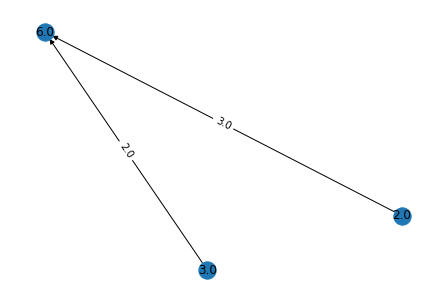

In [144]:
GRAPH.draw()